In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point
import copy
import time

In [2]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
# geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [3]:
geodata['centroid'] = geodata.centroid

In [4]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
281,E09000001,City of London,"POLYGON ((533332.880 180406.812, 531312.428 18...",1,POINT (532386.960 181171.227)
282,E09000002,Barking and Dagenham,"POLYGON ((549989.033 181410.437, 549893.912 18...",1,POINT (548148.802 184983.214)
283,E09000003,Barnet,"POLYGON ((525822.507 198220.521, 525566.689 19...",1,POINT (524112.884 192352.865)
284,E09000004,Bexley,"POLYGON ((550197.607 180624.586, 550675.695 18...",1,POINT (548864.475 175435.253)
285,E09000005,Brent,"POLYGON ((523951.002 185545.750, 525529.383 18...",1,POINT (520198.672 185822.504)
286,E09000006,Bromley,"POLYGON ((544362.785 172374.320, 546620.254 17...",1,POINT (542849.096 165608.562)
287,E09000007,Camden,"POLYGON ((528839.867 187215.913, 530323.717 18...",1,POINT (527725.369 184719.648)
288,E09000008,Croydon,"POLYGON ((533699.518 170735.630, 534467.566 16...",1,POINT (533306.958 163582.267)
289,E09000009,Ealing,"POLYGON ((521737.468 182993.864, 521351.837 17...",1,POINT (515811.156 181658.904)
290,E09000010,Enfield,"POLYGON ((537543.809 199883.107, 537625.114 19...",1,POINT (532339.725 196506.777)


<AxesSubplot:>

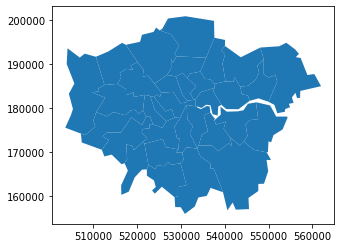

In [5]:
geodata.plot()

In [6]:
neighbours = geodata.sjoin(geodata, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

In [7]:
def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

neighbours['target_angle'] = neighbours.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'target_angle']]

In [8]:
neighbours

,LAD20CD_left,LAD20CD_right,target_angle
281,E09000001,E09000022,-1.797682
286,E09000006,E09000022,2.514451
288,E09000008,E09000022,1.799088
304,E09000024,E09000022,0.763387
308,E09000028,E09000022,-2.456275
...,...,...,...
306,E09000026,E09000002,-0.806490
304,E09000024,E09000021,-2.769225
307,E09000027,E09000021,-1.256605
309,E09000029,E09000021,2.780267


In [9]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['centroid_left'].distance(row['centroid_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [10]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,E09000001,E09000002,21.0,0.237293
2,E09000001,E09000003,18.0,2.207847
3,E09000001,E09000004,24.0,-0.334989
4,E09000001,E09000005,16.0,2.777032
5,E09000001,E09000006,27.0,-0.978932
...,...,...,...,...
1083,E09000033,E09000028,8.0,-0.612246
1084,E09000033,E09000029,25.0,-1.619409
1085,E09000033,E09000030,10.0,0.073124
1086,E09000033,E09000031,18.0,0.751657


In [11]:
orientation_ranking = copy.copy(geodata)[['LAD20CD', 'centroid']]
orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])
orientation_ranking['EW'] = orientation_ranking['x'].rank()
orientation_ranking['NS'] = orientation_ranking['y'].rank()
orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

In [12]:
orientation_ranking

,LAD20CD,EW,NS
281,E09000001,20.0,17.0
282,E09000002,31.0,24.0
283,E09000003,9.0,32.0
284,E09000004,32.0,10.0
285,E09000005,7.0,26.0
286,E09000006,28.0,3.0
287,E09000007,14.0,22.0
288,E09000008,21.0,1.0
289,E09000009,4.0,19.0
290,E09000010,19.0,33.0


In [13]:
# Create an initial grid

scale_factor = 0
sfs = [scale_factor]
scale_factor_interval = len(geodata)/200

initial_grid_size = -1
gss = [initial_grid_size]
full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])

while initial_grid_size < len(geodata):

    scale_factor += scale_factor_interval
    
    initial_y_length = int(np.round(scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
    initial_x_length = int(np.round(axis_ratio*initial_y_length))

    initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
    initial_grid_size = initial_y_length*initial_x_length
    
    sfs.append(scale_factor)
    gss.append(initial_grid_size)

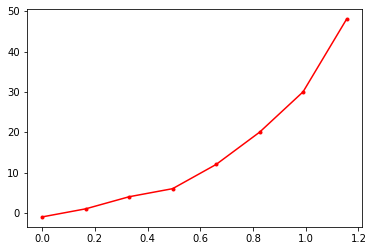

In [14]:
plt.plot(sfs, gss, 'r.-')

In [20]:
neighbour_distance_factor = 10
neighbour_angle_factor = 0

proximity_distance_factor = 10
proximity_angle_factor = 0

packing_factor = 20

orientation_factor = 20

max_move_jump = 1


def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def get_metric(it_gdf):
    
    # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'target_angle']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left').fillna(0)
    
    
    # Define the proximity metric
    it_prox = it_gdf.merge(distance_ranking, left_on='code', right_on='LAD20CD_left')
    it_prox = it_prox.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_prox = it_prox[['code', 'geometry', 'code_r', 'geometry_r', 'target_distance_rank', 'target_angle']]
    
    it_prox['distance'] = it_prox.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_prox['distance_rank'] = it_prox.groupby('code')['distance'].rank()
    it_prox['distance_rank_difference'] = it_prox['distance_rank']-it_prox['target_distance_rank']
    it_prox['angle'] = it_prox.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_prox['angle_diff'] = it_prox.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)
    
    it_prox['proximity_metric'] = it_prox.apply(lambda row: (proximity_distance_factor*row['distance_rank_difference']**2)+(proximity_angle_factor*row['angle_diff']**2), axis=1)
    proximity_metric = it_prox.groupby('code')['proximity_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(proximity_metric, on='code', how='left').fillna(0)
    
    
    # Define the packing metric
    it_pack = copy.copy(it_gdf)
    it_pack['dummy'] = [1]*len(it_pack)
    it_pack = it_pack.merge(it_pack, how='inner', on='dummy', suffixes=('', '_r'))
    it_pack['distance'] = it_pack.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_pack['packing_metric'] = it_pack.apply(lambda row: packing_factor*row['distance']**2, axis=1)
    packing_metric = it_pack.groupby('code')['packing_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(packing_metric, on='code', how='left').fillna(0)
    
    
    # Define the orientation metric
    it_orient = copy.copy(it_gdf)
    it_orient['x'] = it_orient['geometry'].apply(lambda g: g.xy[0][0])
    it_orient['y'] = it_orient['geometry'].apply(lambda g: g.xy[1][0])
    it_orient['EW_current'] = it_orient['x'].rank()
    it_orient['NS_current'] = it_orient['y'].rank()
    it_orient = it_orient.merge(orientation_ranking, left_on='code', right_on='LAD20CD', how='left')
    it_orient['orientation_metric'] = it_orient.apply(lambda row: orientation_factor*((row['EW_current']-row['EW'])**2 + (row['NS_current']-row['NS'])**2), axis=1)
    it_gdf = it_gdf.merge(it_orient[['code', 'orientation_metric']], on='code', how='left')    
    
    
    it_gdf['metric'] = it_gdf['neighbour_metric']+it_gdf['proximity_metric']+it_gdf['packing_metric']+it_gdf['orientation_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def do_swaps(gdf, max_metric):
    
#     max_metric = gdf[gdf['metric']==gdf['metric'].max()]
    original_metric = gdf['metric'].sum()
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
#     for x_shift, EW in zip([-1,0,1], ['W', 'C', 'E']):
#         for y_shift, NS in zip([-1,0,1], ['S', 'C', 'N']):
#             directions.append(NS+EW)
    for x_shift in range(-max_move_jump, max_move_jump+1):
        for y_shift in range(-max_move_jump, max_move_jump+1):
            directions.append((x_shift, y_shift))
            new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
            
            new_df = copy.copy(gdf)
            new_df.loc[(gdf['geometry']==new_loc), 'geometry'] = original_loc
            new_df.loc[(gdf['geometry']==original_loc), 'geometry'] = new_loc
            
            metric_columns = [c for c in new_df.columns if 'metric' in c]
            new_df = get_metric(new_df.drop(columns=metric_columns))
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)] if np.min(metrics) < original_metric else (0,0)
    output_df = new_dfs[np.argmin(metrics)] if np.min(metrics) < original_metric else gdf
    return dir_to_use, new_dfs[np.argmin(metrics)]


def do_iteration(gdf_in):
    
    # THIS IS WHERE I'M WORKING
    # I need to run do_swaps on the dataframe.
    # If there's no change (i.e. d=="CC") then I need to set that row's is_tested to True and run do_swaps again.
    # If I can keep running do_swaps until there's nothing left that can be swapped, we stop.
    
    gdf = copy.copy(gdf_in)
    gdf['is_tested'] = [False]*len(gdf)
    
    all_tested = False    
    iterate = True
    
    old_gdf = copy.copy(gdf)
    while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[(old_gdf['metric']==max_metric) & (old_gdf['is_tested']==False)]
        d, new_gdf = do_swaps(old_gdf, row_to_test)        
        
        if d != (0,0):
            iterate = False
            
        else:
            new_gdf.loc[(new_gdf['metric']==max_metric) & (new_gdf['is_tested']==False), 'is_tested'] = True
            num_tested = new_gdf['is_tested'].sum()
            all_tested = True if num_tested == len(new_gdf) else False
            iterate = True if num_tested < len(new_gdf) else False
            old_gdf = copy.copy(new_gdf)
            
    return all_tested, new_gdf.drop(columns=['is_tested'])

In [21]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values

num_initialisations = 20
initial_dfs = {}
initial_metrics = []
for random_seed in range(num_initialisations):
    initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))
    initial_dfs[random_seed] = find_it_gdf(codes_list, initial_coords)
    initial_metrics.append(initial_dfs[random_seed]['metric'].sum())
    
initial_df = initial_dfs[np.argmin(initial_metrics)]

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

In [17]:
c = 'y'
new_df = initial_df
it = 0

start_time = time.time()

while c == 'y':
    
    ti = time.time()
    
#     f, ax = plt.subplots(figsize=(5,5))
#     ax.axis('off')
    
    old_df = new_df
    met_old = old_df['metric'].sum()
    
    d, new_df = do_iteration(old_df)
    
#     new_df.plot(ax=ax, column='metric')
#     for x, y, label in zip(new_df.geometry.x, new_df.geometry.y, new_df.code):
#         ax.annotate(label[-2:], xy=(x, y), xytext=(0,0), textcoords="offset points")
#     plt.show()  
    
    met_new = new_df['metric'].sum()
    
    c = 'y' if d == False else 'n'
    c = 'n' if met_new > met_old else c
    
    tf = time.time()
    
    print("it "+str(it)+":  "+str(np.round(tf-ti, decimals=1))+' -- '+str(met_new-met_old))
    it+=1
    
#     f.clf()
    
    
total_time = time.time()-start_time
print('TOTAL TIME: '+str(np.round(total_time, decimals=1))+' seconds')

it 0:  5.2 -- -11000.0
it 1:  5.3 -- -13220.0
it 2:  5.0 -- -37600.0
it 3:  5.0 -- -37030.0
it 4:  5.4 -- -12115.0
it 5:  5.1 -- -9550.0
it 6:  5.1 -- -10850.0
it 7:  5.4 -- -15040.0
it 8:  5.1 -- -11785.0
it 9:  5.4 -- -2340.0
it 10:  5.2 -- -5295.0
it 11:  4.9 -- -1685.0
it 12:  4.7 -- -825.0
it 13:  4.9 -- -49660.0
it 14:  4.7 -- -7465.0
it 15:  4.7 -- -11680.0
it 16:  4.9 -- -5800.0
it 17:  4.8 -- -25730.0
it 18:  4.8 -- -10660.0
it 19:  4.7 -- -9770.0
it 20:  4.8 -- -5105.0
it 21:  4.8 -- -5395.0
it 22:  4.8 -- -20430.0
it 23:  4.7 -- -24480.0
it 24:  4.8 -- -12640.0
it 25:  4.8 -- -4085.0
it 26:  4.7 -- -4425.0
it 27:  4.8 -- -49090.0
it 28:  4.7 -- -29290.0
it 29:  5.2 -- -49790.0
it 30:  4.8 -- -45940.0
it 31:  4.8 -- -79050.0
it 32:  4.8 -- -58060.0
it 33:  4.7 -- -49810.0
it 34:  4.9 -- -42920.0
it 35:  5.1 -- -86770.0
it 36:  5.0 -- -25855.0
it 37:  4.7 -- -28580.0
it 38:  4.8 -- -77180.0
it 39:  4.7 -- -18470.0
it 40:  4.9 -- -9440.0
it 41:  4.9 -- -67320.0
it 42:  4.7 -- -

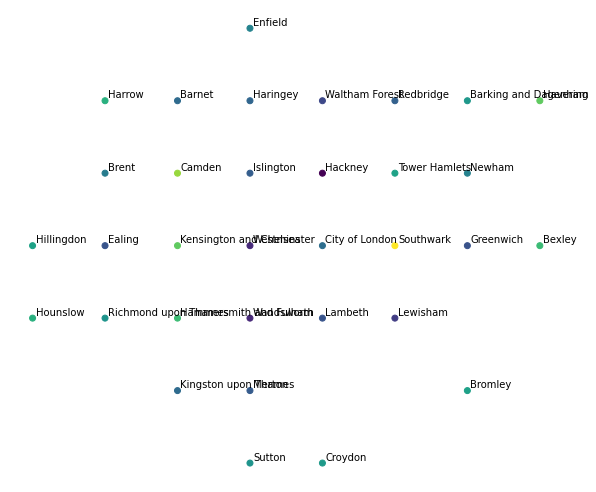

In [19]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

final = new_df[['code', 'geometry', 'metric']].merge(geodata[['LAD20NM', 'LAD20CD']], left_on='code', right_on='LAD20CD')

final.plot(column='metric', ax=ax)

for x, y, label in zip(final.geometry.x, final.geometry.y, final.LAD20NM):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [117]:
final

,code,geometry,metric,LAD20NM,LAD20CD
0,W06000001,POINT (4.000 8.000),990.500651,Isle of Anglesey,W06000001
1,W06000002,POINT (3.000 6.000),2660.139760,Gwynedd,W06000002
2,W06000003,POINT (4.000 7.000),2010.964848,Conwy,W06000003
3,W06000004,POINT (3.000 7.000),3911.406903,Denbighshire,W06000004
4,W06000005,POINT (2.000 8.000),2182.539347,Flintshire,W06000005
5,W06000006,POINT (2.000 7.000),3182.991715,Wrexham,W06000006
6,W06000008,POINT (3.000 4.000),2945.271986,Ceredigion,W06000008
7,W06000009,POINT (5.000 3.000),1870.134753,Pembrokeshire,W06000009
8,W06000010,POINT (4.000 4.000),3262.249519,Carmarthenshire,W06000010
9,W06000011,POINT (4.000 2.000),1916.414167,Swansea,W06000011


In [84]:
new_df['metric'].sum()

286199.5234828118

<AxesSubplot:>

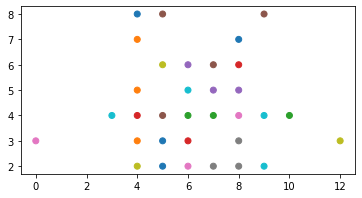

In [284]:
new_df.plot(column='code')

<AxesSubplot:>

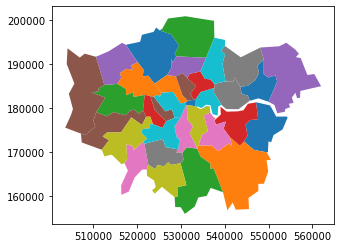

In [279]:
geodata.plot(column='LAD20CD')